<a href="https://colab.research.google.com/github/EQUBAL100/Apna_college_demo_practicing/blob/main/postprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post processing of mumax3 output data in python

When mumax3 is used for actual research, then most likely the RAW output data will need some further processing.
This jupyter notebook demonstrates how mumax3 output data can be processed, analyzed, and visualized using Python. After defining mumax3 helper functions to run mumax3 and read the output data in Python, we will study three different use cases.

Table of contents:
1. [getting ready](#gettingready)
2. [mumax3 helper functions](#helperfunctions)
3. [standard problem 4 revisited](#std4)
4. [skyrmion excitation (temporal fft)](#skyrmionexcitation)
5. [spin wave dispersion (temporal + spatial fft)](#spinwaves)

 <a id='gettingready'></a>
## 1. Getting ready

If you want to run the examples in this notebook, then mumax3 must be is installed on the system that is running this notebook. Go to [mumax.github.io/download](http://mumax.github.io/download) for more information on how to install mumax3 on your system. If you are running this notebook in a google colaboratory session, then it suffices to run the cell below to install mumax3.

In [47]:
try:
    import google.colab
except ImportError:
    pass
else:
    !wget https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
    !tar -xvf mumax3.10_linux_cuda10.1.tar.gz
    !rm mumax3.10_linux_cuda10.1.tar.gz
    !rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10
    import os
    os.environ['PATH'] += ":/content/mumax3.10"

--2025-09-07 14:50:46--  https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
Resolving mumax.ugent.be (mumax.ugent.be)... 157.193.40.77
Connecting to mumax.ugent.be (mumax.ugent.be)|157.193.40.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150707207 (144M) [application/x-gzip]
Saving to: ‘mumax3.10_linux_cuda10.1.tar.gz’

mumax3.10_linux_cud 100%[===================>] 143.73M  21.5MB/s    in 7.9s    

2025-09-07 14:50:55 (18.2 MB/s) - ‘mumax3.10_linux_cuda10.1.tar.gz’ saved [150707207/150707207]

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


In the examples presented in this notebook, we will use the numpy and pandas libraries for post processing mumax3 output data, and matplotlib to visualize this data. So let's import these libraries.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

 <a id='helperfunctions'></a>
## 2. mumax3 helper functions

Let's start by writing a function which reads a mumax3 output table and puts the date in a Pandas dataframe.

In [49]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table

    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]

    return table

Mumax3 does not only write output data in a table, it can also write field data to ovf files. The function below converts all ovf files in the output directory to numpy files. These files are then loaded using the numpy.load function. The result is a python dictionary of the field data (a numpy array) with the ovf filename as key.

In [50]:
def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays
    with the ovffilename (without extension) as key"""

    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)

    return fields

The function below executes a mumax3 script and returns the data of the output table in a pandas dataframe, and the saved fields as numpy arrays.

In [51]:
def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files

    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """

    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt"
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)

    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None

    fields = read_mumax3_ovffiles(outputdir)

    return table, fields

 <a id='std4'></a>
## 3. Standard problem 4 revisited

Let's start by putting the mumax3 input script for standard problem 4 in the string variable `script`.

In [52]:
script="""
SetGridsize(128, 32, 1)
SetCellsize(500e-9/128, 125e-9/32, 3e-9)

Msat  = 800e3
Aex   = 13e-12
alpha = 0.02

m = uniform(1, .1, 0)
relax()

autosave(m, 200e-12)
tableadd(e_total)
tableautosave(10e-12)

B_ext = vector(-24.6E-3, 4.3E-3, 0)
run(1e-9)
"""

Now we can execute this mumax3 script using the `run_mumax3` helper function. This function returns the output table in a pandas dataframe and a dictionary of the saved fields. If `verbose=True`, then the log output of mumax3 will be printed out when mumax3 finishes. Note that on the left side of the cell, you can check if the simulation is finished or still running.

In [53]:
table, fields = run_mumax3( script, name="standardproblem4", verbose=False )

The table data is put in a pandas dataframe. This makes it very easy to plot and analyze the table data.

                t        mx        my        mz       E_total
0    0.000000e+00  0.966966  0.125279  0.000000  4.113436e-18
1    1.077579e-11  0.963728  0.136216 -0.013442  4.112612e-18
2    2.060576e-11  0.954719  0.163910 -0.025058  4.109956e-18
3    3.062387e-11  0.938156  0.207496 -0.035985  4.103893e-18
4    4.059884e-11  0.912535  0.263429 -0.045664  4.093553e-18
..            ...       ...       ...       ...           ...
96   9.605469e-10 -0.969447 -0.076252 -0.002054 -2.657373e-18
97   9.701195e-10 -0.975263 -0.061756  0.016799 -2.666007e-18
98   9.803688e-10 -0.983797 -0.015025  0.033130 -2.679808e-18
99   9.906135e-10 -0.988105  0.054575  0.042455 -2.699119e-18
100  1.000000e-09 -0.984612  0.126044  0.043269 -2.718244e-18

[101 rows x 5 columns]


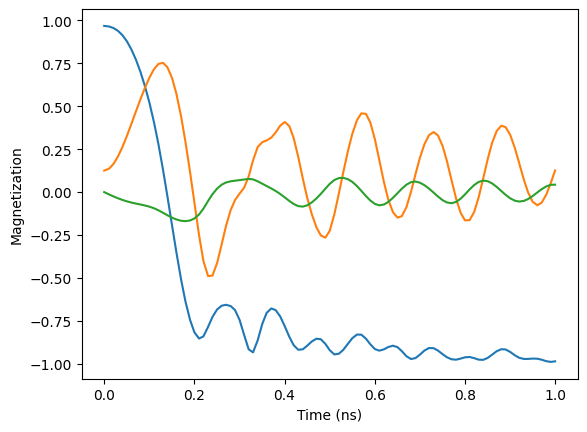

In [54]:
print(table)

plt.figure()

nanosecond = 1e-9
plt.plot( table["t"]/nanosecond, table["mx"])
plt.plot( table["t"]/nanosecond, table["my"])
plt.plot( table["t"]/nanosecond, table["mz"])

plt.xlabel("Time (ns)")
plt.ylabel("Magnetization")

plt.show()

Let's print out the keys of the field dictionary to get an idea about the content of this dictionary:

In [55]:
print(fields.keys())

dict_keys(['m000004', 'm000003', 'm000000', 'm000002', 'm000001', 'm000005'])


As you can see, the dictionary contains 6 fields with keys corresponding to the ovf filenames (without extension). Now, let's focus on the first field 'm000000'.

In [56]:
m = fields["m000000"]

print("type  =", type(m))
print("shape =", m.shape)

type  = <class 'numpy.ndarray'>
shape = (3, 1, 32, 128)


Note that the field data is stored in a 4D numpy array: `m[ic,iz,iy,ix]` with `ic` the index for the magnetization component (X=0,Y=1,Z=2), and with `(ix,iy,iz)` the cell index. We can now use the numpy and matplotlib libraries to process and visualize the field date. E.g. the cell below demonstrates how one can easily create an intensity plot of the absolute value of $m_y$

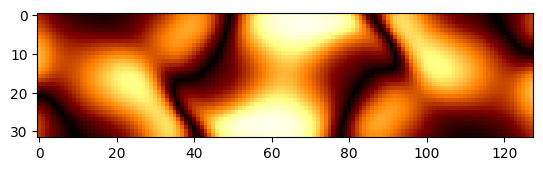

In [57]:
def show_abs_my(m):
    my_abs = np.abs( m[1,0,:,:] )
    plt.figure()
    plt.imshow(my_abs, vmin=0, vmax=1, cmap="afmhot")
    plt.show()

show_abs_my(fields["m000001"])

 <a id='skyrmionexcitation'></a>
## 4. Skyrmion excitation

In this section, we will study the excitation spectrum of a skyrmion in a nanodisc. This example is largely based on [this PRB paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.90.064410) by Joo-Von Kim and Felipe Garcia-Sanchez.

The mumax3 script belows excites the skyrmion with a sinc pulse with maximum frequency of 50GHz. This means that we will excite modes with frequencies below 50GHz.

In [58]:
# NUMERICAL PARAMETERS RELEVANT FOR THE SPECTRUM ANALYSIS
fmax = 50e9        # maximum frequency (in Hz) of the sinc pulse
T    = 2e-9        # simulation time (longer -> better frequency resolution)
dt   = 1/(2*fmax)  # the sample time (Nyquist theorem taken into account)

# Note that this is a format string, this means that the statements inside the
# curly brackets get evaluated by python. In this way, we insert the values of
# the variables above in the script.
script=f"""
diam := 100e-9
nx   := 32
setgridsize(nx,nx,1)
setcellsize(diam/nx,diam/nx,1e-9)
setgeom(circle(diam))

Msat = 1e6
Aex = 15e-12
Dind = 3.0e-3
Ku1 = 1e6
AnisU = vector(0,0,1)
alpha = 0.001

t0 := 1/({fmax})
B_ext = vector(0, 0, 0.0005 * sinc( 2*pi*{fmax}*(t-t0)))
m = neelskyrmion(-1,1)
minimize()

autosave(m,{dt})
tableautosave({dt})
run({T})
"""

table, fields = run_mumax3(script,"skyrmion")

The excitation spectrum of the skyrmion, can be found by taking the Fast Fourier Transform (FFT) of the spatial average of the magnetization deviation $m_z(t)-m_z(0)$.

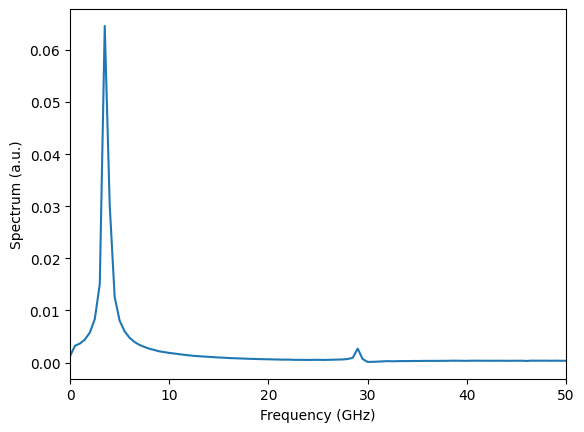

In [59]:
# FAST FOURIER TRANSFORM
dm     = table["mz"] - table["mz"][0]   # average magnetization deviaton
spectr = np.abs(np.fft.fft(dm))         # the absolute value of the FFT of dm
freq   = np.linspace(0, 1/dt, len(dm))  # the frequencies for this FFT

# PLOT THE SPECTRUM
plt.plot(freq/1e9, spectr)
plt.xlim(0,fmax/1e9)
plt.ylabel("Spectrum (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.show()

There are clearly two peaks in the excitation spectrum. One can find the corresponding frequencies using a peak finding algorithm. Here, we will just determine the position of the peaks visually.

Mode 1 frequency: 3.50 GHz
Mode 2 frequency: 29.00 GHz


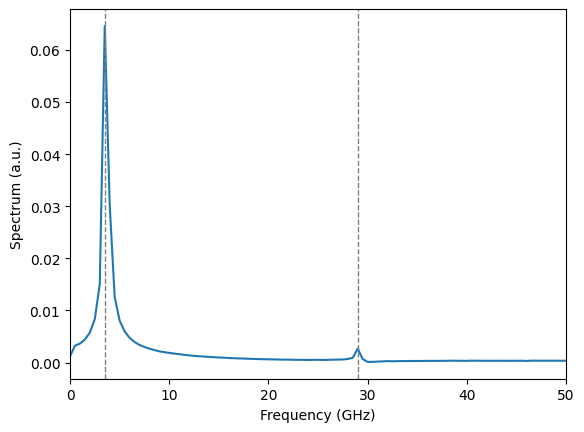

In [60]:
# MODE IDENTIFICATION
mode1_idx = 7   # determined visually
mode2_idx = 58  # determined visually
mode1_freq = freq[mode1_idx]
mode2_freq = freq[mode2_idx]
print("Mode 1 frequency: %.2f GHz"%(mode1_freq/1e9))
print("Mode 2 frequency: %.2f GHz"%(mode2_freq/1e9))

# PLOT THE SPECTRUM
plt.plot(freq/1e9, spectr)
plt.axvline(mode1_freq/1e9, lw=1, ls='--', c='gray')
plt.axvline(mode2_freq/1e9, lw=1, ls='--', c='gray')
plt.xlim(0,fmax/1e9)
plt.ylabel("Spectrum (a.u.)")
plt.xlabel("Frequency (GHz)")
plt.show()

We have found the resonant frequencies by applying a FFT on the average magnetization. In addition, we can apply the FFT on the magnetization in every cell to get more information on these resonant modes.

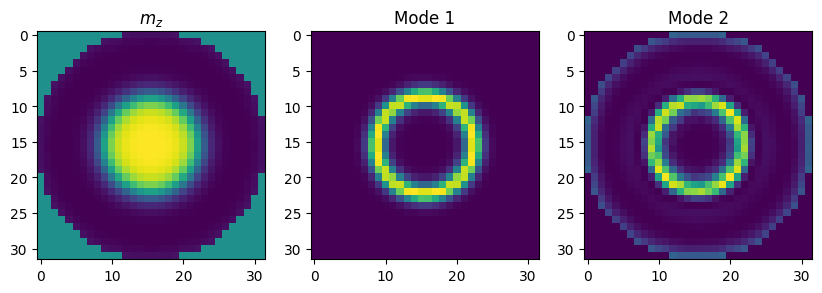

In [61]:
# Stack all snapshots (4D arrays) of the magnetization on top of each other
# The results in a single 5D array (first index is the snapshot index)
m = np.stack([fields[key] for key in sorted(fields.keys())])

# Select the z component and the (only) layer z=0
mz = m[:,2,0,:,:]

# Apply the FFT for every cell
mz_fft = np.fft.fft(mz, axis=0)

# Select the the two modes
mode1 = mz_fft[mode1_idx]
mode2 = mz_fft[mode2_idx]

# Plot the result
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("$m_z$")
plt.imshow(mz[0])
plt.subplot(1,3,2)
plt.title("Mode 1")
plt.imshow(np.abs(mode1)**2)
plt.subplot(1,3,3)
plt.title("Mode 2")
plt.imshow(np.abs(mode2)**2)
plt.show()

 <a id='spinwaves'></a>
## 5. Ferromagnetic spinwave dispersion relation

Disregarding dipole-dipole interactions, the dispersion relation $f(k)$ in a ferromagnetic wire is given by

$$  f(k) = \frac{\gamma}{2\pi}\left[ \frac{2A}{M_s} k^2 + B \right] $$

with $A$ the exchange stiffness, $M_s$ the saturation magnetization, and $B$ an externally applied field. In this section, we will try to reproduce this dispersion relation numerically using mumax3.

The mumax3 script below simulates a uniformly magnetized nanowire with an applied field perpendicular to the wire. Spin waves are excited by a sinc pulse with a maximum frequency of 20GHz at the center of the simulation box. Note that the demagnetization is disabled in this simulation.

In [62]:
# NUMERICAL PARAMETERS
fmax = 20e9        # maximum frequency (in Hz) of the sinc pulse
T    = 1e-8        # simulation time (longer -> better frequency resolution)
dt   = 1/(2*fmax)  # the sample time
dx   = 4e-9        # cellsize
nx   = 1024        # number of cells

# MATERIAL/SYSTEM PARAMETERS
Bz    = 0.2        # Bias field along the z direction
A     = 13e-12     # exchange constant
Ms    = 800e3      # saturation magnetization
alpha = 0.05       # damping parameter
gamma = 1.76e11    # gyromagnetic ratio

# Note that this is a format string, this means that the statements inside the
# curly brackets get evaluated by python. In this way, we insert the values of
# the variables above in the script.
script=f"""
setgridsize({nx},1,1)
setcellsize({dx},{dx},{dx})

enabledemag = false
Aex = {A}
Msat = {Ms}
alpha = {alpha}

Bz := {Bz}
B_ext = vector(0,0,{Bz})
defregion(1,rect(2*{dx},inf))
B_ext.setregion(1, vector(0.01 * sinc( 2*pi*{fmax}*(t-{T}/2)), 0, {Bz}))

m = uniform(0,0,1)
autosave(m,{dt})
run({T})
"""

table, fields = run_mumax3(script,"spinwaves")

Applying the 2D Fast Fourier Transform on the magnetization snapshots yield the dispersion relation of the ferromagnetic nanowire.

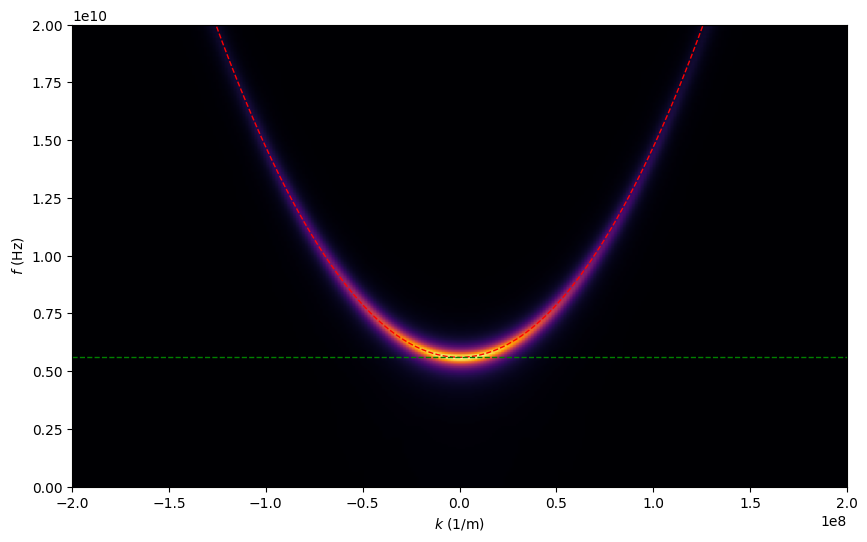

In [63]:
# Stack all snapshots of the magnetization on top of each other
m = np.stack([fields[key] for key in sorted(fields.keys())])

# Select the x component
mx = m[:,0,0,0,:]

# Apply the two dimensional FFT
mx_fft = np.fft.fft2(mx)
mx_fft = np.fft.fftshift(mx_fft)

plt.figure(figsize=(10,6))

# Show the intensity plot of the 2D FFT
extent = [ -(2*np.pi)/(2*dx), (2*np.pi)/(2*dx), -1/(2*dt), 1/(2*dt)] # extent of k values and frequencies
plt.imshow(np.abs(mx_fft)**2, extent=extent, aspect='auto', origin='lower', cmap="inferno")

# Plot the analytical derived dispersion relation
k = np.linspace(-2e8,2e8,1000)
freq_theory = A*gamma*k**2 /(np.pi*Ms) + gamma*Bz /(2*np.pi)
plt.plot(k,freq_theory,'r--',lw=1)
plt.axhline(gamma*Bz/(2*np.pi),c='g',ls='--',lw=1)

plt.xlim([-2e8,2e8])
plt.ylim([0,fmax])
plt.ylabel("$f$ (Hz)")
plt.xlabel("$k$ (1/m)")

plt.show()